## 1. Goal:

Develop a single portfolio optimization that rebalances the portfolio back to the model (minimize the deviations 
between portfolio holding and model target weights) while keeping the total trading cost (sum of each 
holding trading cost) below a certain dollar amount.
Assumptions & Conditions:
- The problem can handle any number of securities
- Stocks can be traded at any fractional unit
- Shorting is not allowed 
- The trading cost of a holding is 3% of its traded amount
- The total trading cost cannot exceed $7,500
- Deviations between portfolio and model weights should be measured as the square of the 
difference in weights


## 2. Model Formulation

#### Constants

Assume the following constants are known:
* $P_{0}$ the current dollar position vector
* $\omega^{\star}$ the target portfolio weights
* $\lambda$ the fractional trading cost (3% in this example)
* $C_{max}$ the maximum trading cost ($7500 in this example)

### Base Problem Formulation

The problem can be formulated as solving for new postions $P$:

$$
\text{min } \lVert\omega^{\star}-\frac{P}{1^{\top}P}\rVert^2
$$

such that

$$
\begin{align}
P \geq && 0 \\
\lambda \sum_{i} |P_{0,i}-P_{i}| \leq && C_{max} \\
\end{align}
$$

### Reformulation 1

Define $m_{0}=\frac{1}{1^{\top}P}$ and solve

$$
\text{min }\lVert\omega^{\star}-m_{0}P\rVert^{2}
$$

such that
$$
\begin{align}
m_{0}\geq && 0 \\
m_{0}P\geq && 0 \\
\lambda\sum_{i}|m_{0}P_{0,i}-m_{0}P_{i}|\leq && C_{max}m_{0} \\
m_{0}1^{\top}P= && 1 \\
\end{align}
$$

### Reformulation 2

Define $m=m_{0}P$ and solve

$$
\text{min }\lVert\omega^{\star}-m\rVert^{2}
$$

such that

$$
\begin{align}
m_{0}\geq && 0 \\
m\geq && 0 \\
\lambda\sum_{i}|m_{0}P_{0,i}-m_{i}|\leq && C_{max}m_{0} \\
1^{\top}m= && 1 \\
\end{align}
$$

### Reformulation 3

We need to remove the absolute value constraint by introducing extra variables $z$

$$
\text{min }\lVert\omega^{\star}-m\rVert^{2}
$$

such that

$$
\begin{align}
m_{0}\geq && 0 \\
m\geq && 0 \\
1^{\top}m= && 1 \\
-z \leq && m_{0}P_{0}-m \\
m_{0}P_{0} -m \leq && z \\
\lambda1^{\top}z = && C_{max}m_{0} \\
\end{align}
$$


## 3. Python Implementation

```
pip install cvxpy numpy pandas matplotlib
```

In [1]:
import cvxpy as cvx
import pandas as pd
import numpy as np

def rebalance(pos_curr, w_tgt, frac_tc, max_tot_tc):
    """ Calculate optimal rebalanced weights by minimizing distance to target weights
    subject to transaction cost constraints.  See documentation above.
    
    Args
    ----
    pos_curr : np.ndarray
        Current dollar positions
        
    w_tgt : np.ndarray
        Target weight vector
        
    frac_tc : float
        Fractional transaction costs
    
    max_tot_tc : float
        Maximum transaction costs to be paid
        
    Returns
    -------
    w_new : np.ndarray
        New portfolio weights
    
    """
    n_instrument = pos_curr.shape[0]

    m0 = cvx.Variable(1)
    m = cvx.Variable(n_instrument)
    z = cvx.Variable(n_instrument)
    
    objective = cvx.Minimize(cvx.sum_squares(w_tgt - m))
    
    constraints = [
        m0 >= 0,
        m >= 0,
        cvx.sum(m) == 1,
        -z <= m0*pos_curr - m,
        m0*pos_curr - m <= z,
        frac_tc * cvx.sum(z) == max_tot_tc * m0]
        
    problem = cvx.Problem(objective, constraints)
    # solution = problem.solve(solver=cvx.ECOS, max_iters=1000, abstol=1e-9, reltol=1e-9, feastol=1e-10)
    solution = problem.solve(solver=cvx.ECOS)
    
    w_new = m.value
    
    return w_new


## 4. Example Portfolio

In [2]:
TC_RATE = 0.03
TC_LIMIT = 7500
INSTRUMENTS = [
    {'stock':'A','shares_0':5000, 'price_1': 63, 'tgt_weight': 0.50},
    {'stock':'B','shares_0':1500, 'price_1': 277, 'tgt_weight':0.30},
    {'stock':'C','shares_0':4000, 'price_1': 88, 'tgt_weight': 0.20}]

df = pd.DataFrame(INSTRUMENTS)

df['pos_initial'] = df.shares_0 * df.price_1 
df['weight_initial'] = df.pos_initial / df.pos_initial.sum()
df['rebalanced_weight'] = rebalance(pos_curr = df.pos_initial.values,
              w_tgt = df.tgt_weight.values, frac_tc = TC_RATE,
              max_tot_tc = TC_LIMIT)

df

,stock,shares_0,price_1,tgt_weight,pos_initial,weight_initial,rebalanced_weight
0,A,5000,63,0.5,315000,0.290993,0.421332
1,B,1500,277,0.3,415500,0.383834,0.322838
2,C,4000,88,0.2,352000,0.325173,0.255830


## 5. Sanity Check

In [3]:
tc_limits = np.linspace(100, 20000, 50)
objective = np.zeros_like(tc_limits)

for i, tc in enumerate(tc_limits):
    w = rebalance(pos_curr = df.pos_initial.values,
                  w_tgt = df.tgt_weight.values,
                  frac_tc = TC_RATE,
                  max_tot_tc = tc)
    
    objective[i] = np.sum((w-df.tgt_weight)**2)


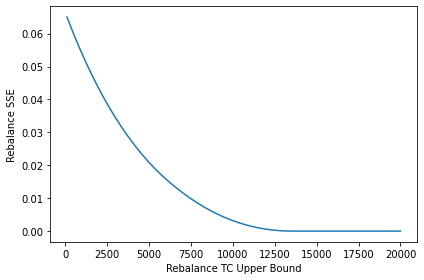

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.plot(tc_limits, objective)

ax.set_ylabel('Rebalance SSE')
ax.set_xlabel('Rebalance TC Upper Bound')

plt.tight_layout()